In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import sys
#sys.path = [x for x in sys.path if x !='/private/home/costajussa/.local/lib/python3.8/site-packages' ]
import os

import torch
torch.cuda.set_device(1)
torch.cuda.current_device()

import warnings
from pathlib import Path

from wrappers.multilingual_transformer_wrapper import FairseqMultilingualTransformerHub

from fairseq.data.multilingual.multilingual_utils import (
    EncoderLangtok,
    LangTokSpec,
    LangTokStyle,
    augment_dictionary,
    get_lang_tok,
)

import alignment.align as align

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
import numpy as np
import fairseq

import logging
logger = logging.getLogger()
logger.setLevel('WARNING')
#warnings.simplefilter('ignore')

from dotenv import load_dotenv
load_dotenv()
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load model

Choose model size (small/big), and data mode ()

In [3]:
model_size = 'small' # small (412M) /big (1.2B)
data_sample = 'interactive' # generate/interactive
teacher_forcing = True # teacher forcing/free decoding

In [4]:
# Paths
# Checkpoint path
#ckpt_dir = Path(os.environ['M2M_CKPT_DIR'])
#ckpt_dir = Path(os.environ['/large_experiments/nllb/mmt/h2_21_models/flores125_v3.3/en_to_many_to_en/v3.3_dense_hrft004.mfp16.mu100000.uf4.lss.enttgt.tmp1.0.shem.NBF.warmup8000.lr0.004.drop0.0.maxtok2560.seed2.valevery200000.max_pos512.adam16bit.fully_sharded.det.transformer.ELS24.DLS24.encffnx8192.decffnx8192.E1024.H16.ATTDRP0.1.RELDRP0.0.ngpu128/'])
ckpt_dir = '/large_experiments/nllb/mmt/h2_21_models/flores125_v3.3/en_to_many_to_en/v3.3_dense_hrft004.mfp16.mu100000.uf4.lss.enttgt.tmp1.0.shem.NBF.warmup8000.lr0.004.drop0.0.maxtok2560.seed2.valevery200000.max_pos512.adam16bit.fully_sharded.det.transformer.ELS24.DLS24.encffnx8192.decffnx8192.E1024.H16.ATTDRP0.1.RELDRP0.0.ngpu128/'

# Path to binarized data
if data_sample == 'generate':
#    m2m_data_dir = Path(os.environ['M2M_DATA_DIR'])
#    data_name_or_path=(f'{m2m_data_dir}/data_bin')
    data_name_or_path='/large_experiments/nllb/mmt/multilingual_bin/flores125.en_xx_en.v3.3/data_bin/shard000/'
else:
    # use "." to avoid loading
    data_name_or_path='.'

# Chackpoint names
#if model_size=='big':
checkpoint_file = 'checkpoint_15_100000_consolidated.pt'
#else:
#    checkpoint_file = 'checkpoint_15_100000_consolidated.pt'

In [5]:
hub = FairseqMultilingualTransformerHub.from_pretrained(
    ckpt_dir,
    checkpoint_file=checkpoint_file,
    data_name_or_path=data_name_or_path,
    dict_path='/large_experiments/nllb/mmt/multilingual_bin/flores125.en_xx_en.v3.3/data_bin/shard000/dict.eng.txt',
    source_lang= 'deu',
    target_lang= 'eng',
    lang_pairs ='deu-eng')
NUM_LAYERS = 12

## Get sample for analysis

### Get sample from provided test data (preprocessed folder)

In [6]:
if data_sample=='generate':

    i = 3

    src_sent, src_tok, src_tensor, tgt_sent, tgt_tok, tgt_tensor = hub.get_sample('test', i)


    print(f"\nSource sentence: \t {src_sent}")
    print(f"Target sentence: \t {tgt_sent}")

    src_lan_token = get_lang_tok(lang=hub.task.source_langs[0], lang_tok_style=LangTokStyle.multilingual.value)
    tgt_lan_token = get_lang_tok(lang=hub.task.target_langs[0], lang_tok_style=LangTokStyle.multilingual.value)


### Get sample as interactive from tokenized file

In [7]:
if data_sample=='interactive':

    # Get sample from Gold alignment dataset (SPM)
    gold_alignment_dir = Path("./data")
    test_de_bpe =  gold_alignment_dir / "test.spm.deu"
    test_de_word =  gold_alignment_dir / "test.deu"
    test_en_bpe = gold_alignment_dir / "test.spm.eng"
    test_en_word = gold_alignment_dir / "test.eng"

    with open(test_de_bpe, encoding="utf-8") as fbpe:
        # BPE source sentences
        src_bpe_sents = fbpe.readlines()
    with open(test_en_bpe, encoding="utf-8") as fbpe:
        # BPE target sentences
        tgt_bpe_sents = fbpe.readlines()
    with open(test_de_word, encoding="utf-8") as fword:
        # Original source sentences
        src_word_sents = fword.readlines()
    with open(test_en_word, encoding="utf-8") as fword:
        # Original target sentences
        tgt_word_sents = fword.readlines()

    # index in dataset
    i = 3 # index in dataset
    # 3, 37, 105
    src_word_sent = src_word_sents[i]
    print(src_word_sent)
    tgt_word_sent = tgt_word_sents[i]
    print(tgt_word_sent)

    src_tok_str = src_bpe_sents[i].strip() # removes leading and trailing whitespaces
    src_tok = src_tok_str.split()

    tgt_tok_str = tgt_bpe_sents[i].strip() # removes leading and trailing whitespaces
    tgt_tok = tgt_tok_str.split()

    # M2M generate has --decoder-langtok --encoder-langtok src
    # adds source language token to the source sentence
    # adds target language token to the target sentence
    src_lan_token = get_lang_tok(lang=hub.task.source_langs[0], lang_tok_style=LangTokStyle.multilingual.value)
    tgt_lan_token = get_lang_tok(lang=hub.task.target_langs[0], lang_tok_style=LangTokStyle.multilingual.value)
    idx_src_lan_token = hub.task.source_dictionary.index(src_lan_token)
    idx_tgt_lan_token = hub.task.target_dictionary.index(tgt_lan_token)

    src_tok = [src_lan_token] + src_tok + [hub.task.source_dictionary[hub.task.source_dictionary.eos_index]]
    tgt_tok = [hub.task.target_dictionary[hub.task.target_dictionary.eos_index]] + [tgt_lan_token] + tgt_tok

    src_tensor = torch.tensor([hub.task.source_dictionary.index(s) for s in src_tok])
    tgt_tensor = torch.tensor([hub.task.target_dictionary.index(t) for t in tgt_tok])

herr kommissar , liebe kolleginnen und kollegen ! zunächst herzlichen dank , herr burtone , für ihren bericht .

commissioner , ladies and gentlemen , i should like to begin by thanking mr burtone for his report .



### Teacher Forcing

In [8]:
if teacher_forcing:
    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

    print("\n\nGREEDY DECODING\n")
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    pred_tok = hub.decode(pred_tensor, hub.task.target_dictionary)
    pred_sent = hub.decode(pred_tensor, hub.task.target_dictionary, as_string=True)
    print(f"Predicted sentence: \t {pred_sent}")
    target_sentence = ['</s>'] + [tgt_lan_token] + tgt_tok



GREEDY DECODING

Predicted sentence: 	 __deu__ Herrer , liebeadies and gentllemrs first thank like to thank by thanking you.tonone for his report.</s>


### Free decoding (nbest translations)

In [9]:
if not teacher_forcing:
    tgt_tensor_free = []
    print("\n\nBEAM SEARCH\n")
    for pred in hub.generate(src_tensor, 5,verbose=True):
        tgt_tensor_free.append(pred['tokens'])
        pred_sent = hub.decode(pred['tokens'], hub.task.target_dictionary, as_string=True)
        score = pred['score'].item()
        print(f"{score} \t {pred_sent}")

    hypo = 0 # first hypothesis
    tgt_tensor = tgt_tensor_free[hypo]
    
    # We add eos token at the beginning of sentence and delete it from the end
    tgt_tensor = torch.cat([torch.tensor([hub.task.target_dictionary.eos_index]).to(tgt_tensor.device),
                    tgt_tensor[:-1]
                ]).to(tgt_tensor.device)
    tgt_tok = hub.decode(tgt_tensor, hub.task.target_dictionary, as_string=False)
    target_sentence = tgt_tok
    pred_tok = tgt_tok

    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

    print(f"\n\nGREEDY DECODING with hypothesis {hypo+1}\n")
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    pred_tok = hub.decode(pred_tensor, hub.task.target_dictionary)
    pred_sent = hub.decode(pred_tensor, hub.task.target_dictionary, as_string=True)
    print(f"Predicted sentence: \t {pred_sent}")

In [10]:
source_sentence = src_tok
target_sentence = tgt_tok
predicted_sentence = pred_tok

![enc_dec](./img/enc_dec.png)

## ALTI analysis

### ALTI of the encoder

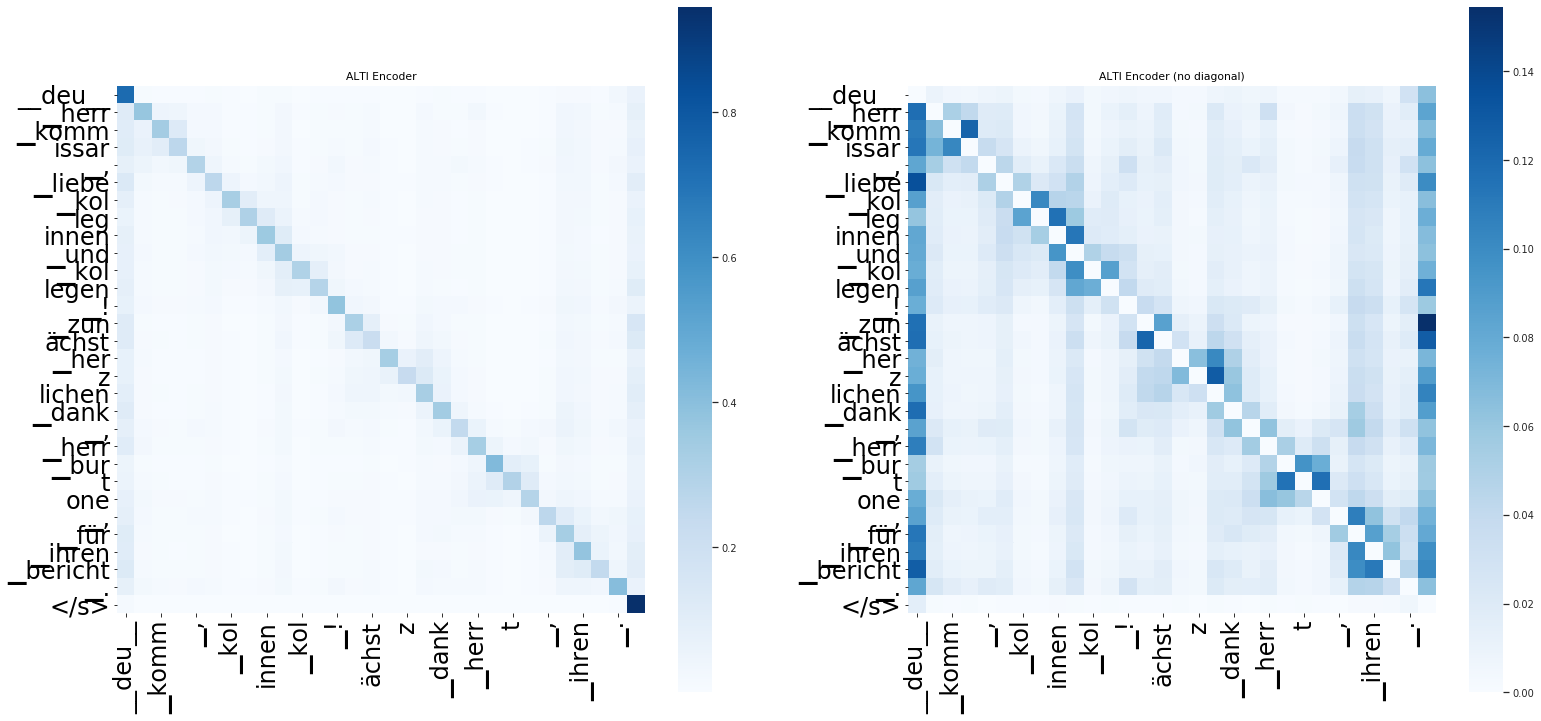

In [11]:
relevances_enc_self_attn = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1',
                                                        norm_modese='min_sum', pre_layer_norm=True)['encoder.self_attn']
                                                        
# Encoder self-attention relevances in last layer (full encoder ALTI)
fig = plt.figure(figsize=(26, 14))
gs = GridSpec(1, 2)
gs.update(wspace=0.2, hspace=0.05)#0.015
ax_left = plt.subplot(gs[0, 0])
ax_right = plt.subplot(gs[0, 1])
relevances_enc_self_attn_last = relevances_enc_self_attn[-1]
relevances_enc_self_attn_last_no_diag = relevances_enc_self_attn_last - torch.diag(relevances_enc_self_attn_last.diag())
df = pd.DataFrame(relevances_enc_self_attn_last.cpu().detach().numpy(),columns= source_sentence, index = source_sentence)
sns.set(font_scale=0.9)
sns.heatmap(df,cmap="Blues",ax=ax_left,square=True)
ax_left.set_title('ALTI Encoder')

df = pd.DataFrame(relevances_enc_self_attn_last_no_diag.cpu().detach().numpy(),columns= source_sentence, index = source_sentence)
sns.heatmap(df,cmap="Blues",ax=ax_right,square=True)
ax_right.set_title('ALTI Encoder (no diagonal)')
plt.gcf().subplots_adjust(bottom=0.2)

### ALTI of the entire model

In [12]:
total_rollout = hub.get_contribution_rollout(src_tensor, tgt_tensor,
                                            'l1', norm_mode='min_sum',
                                            pre_layer_norm=True)['total']

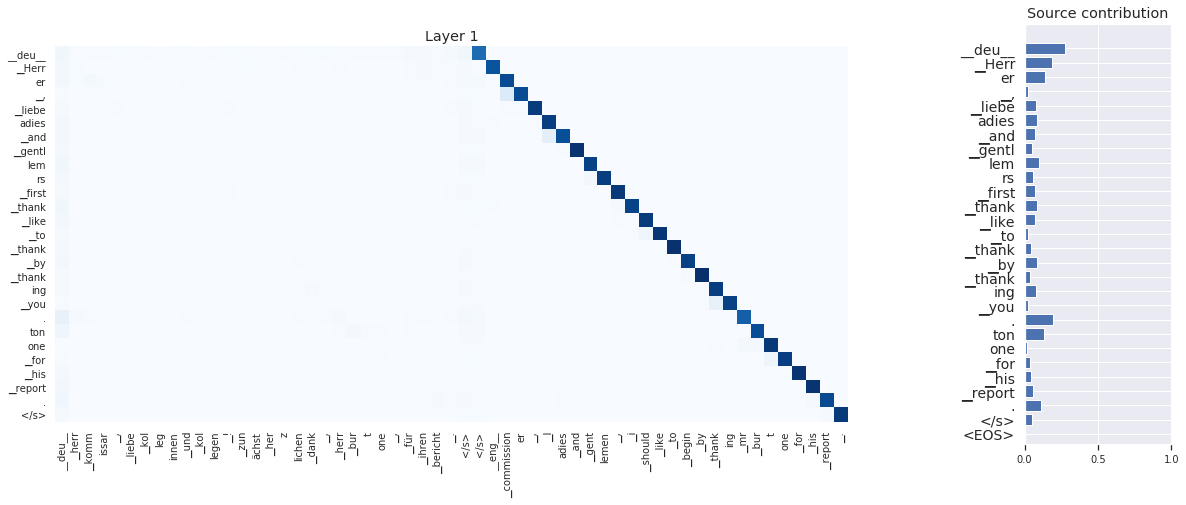

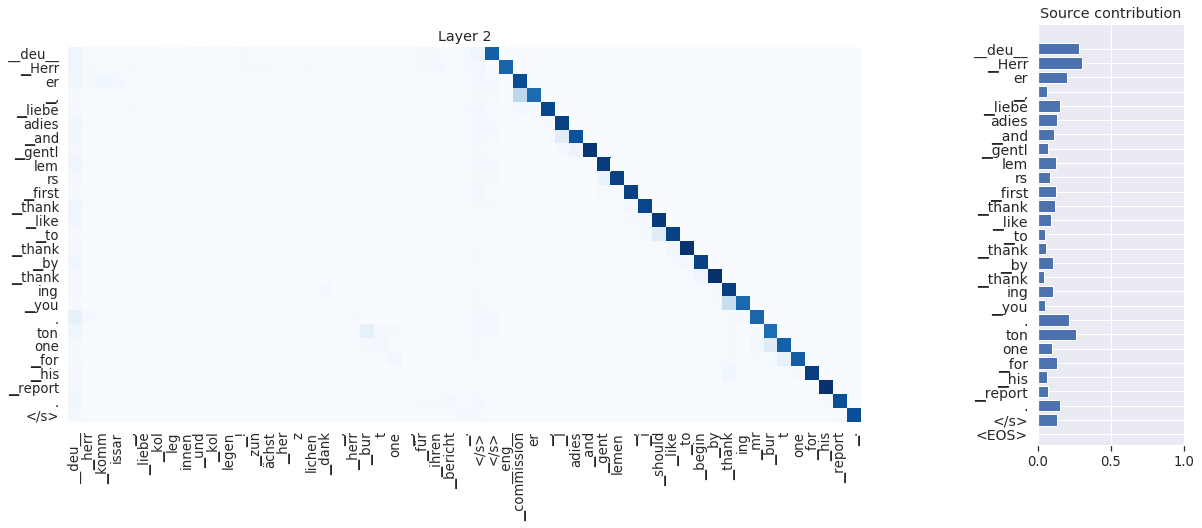

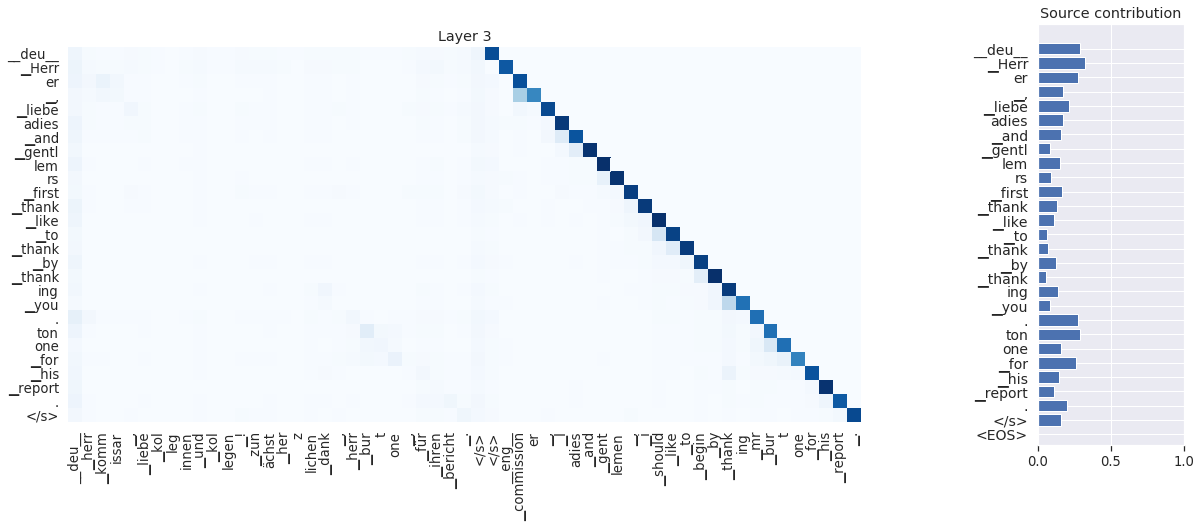

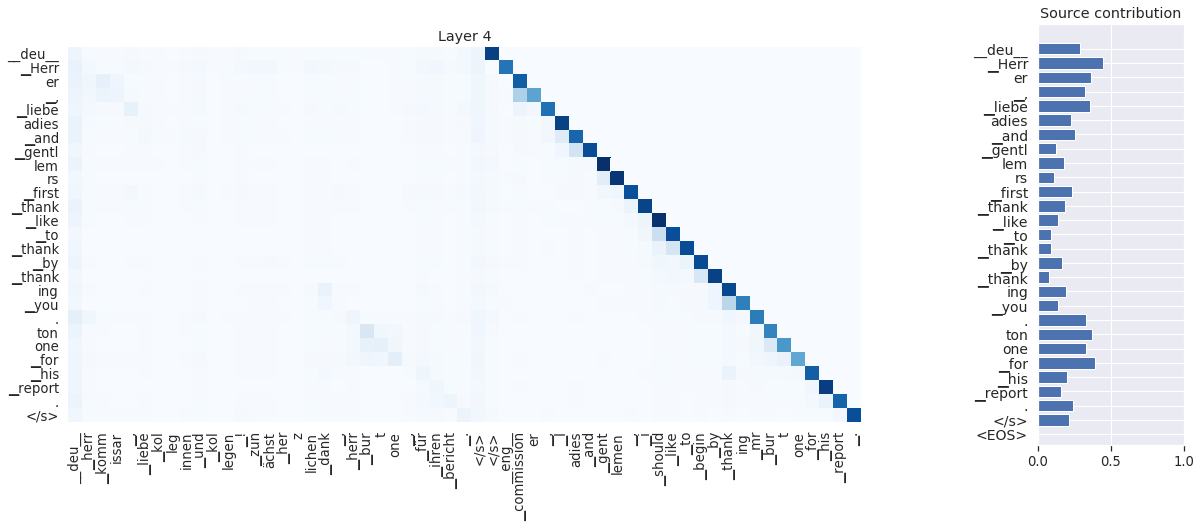

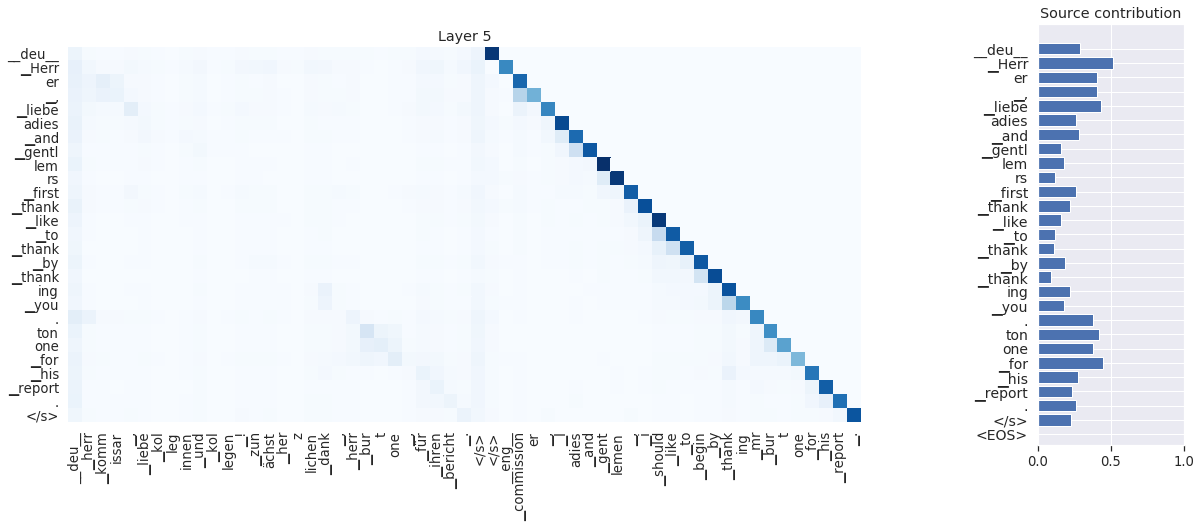

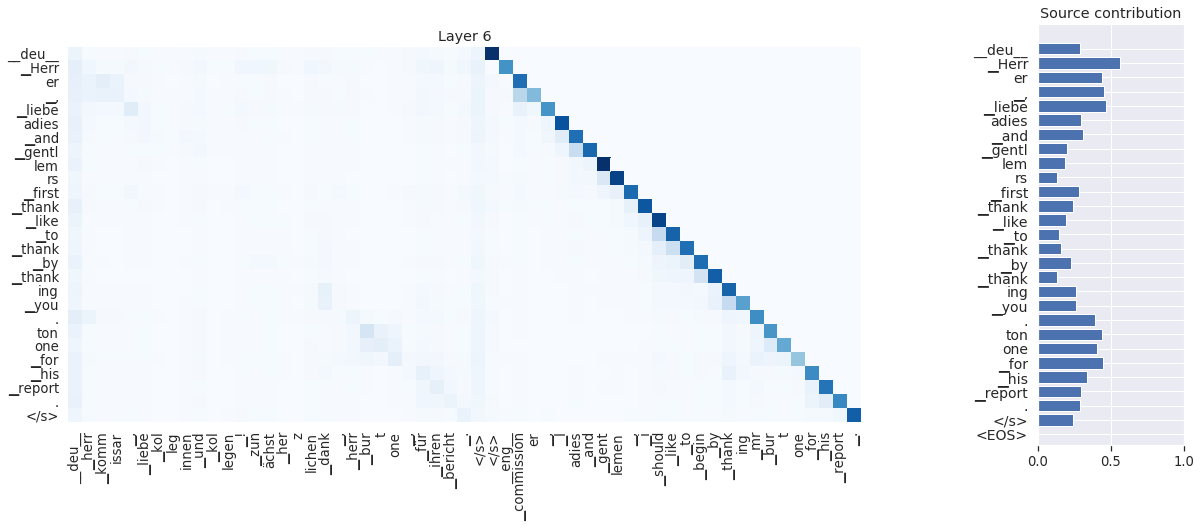

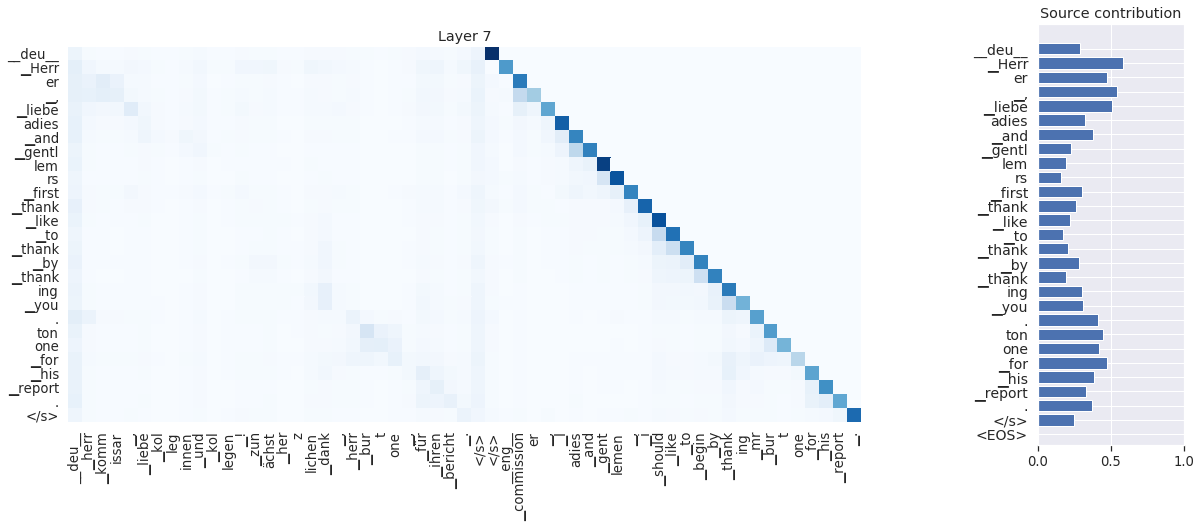

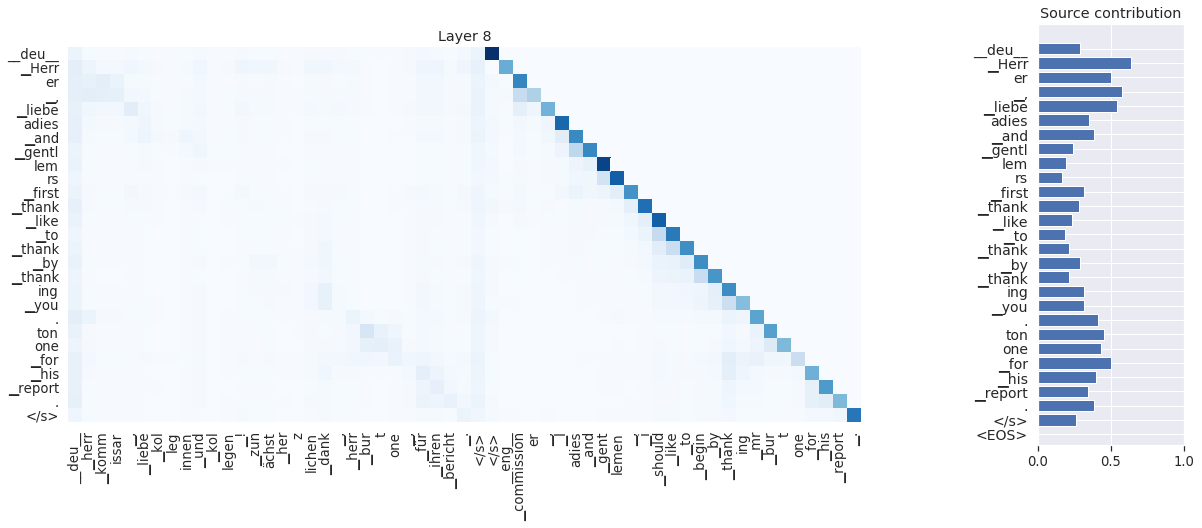

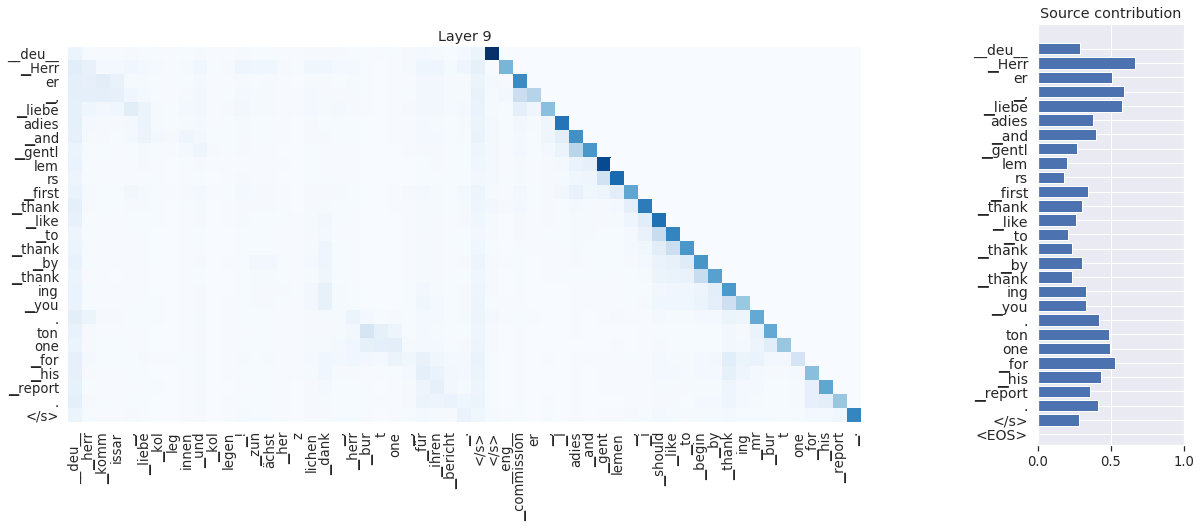

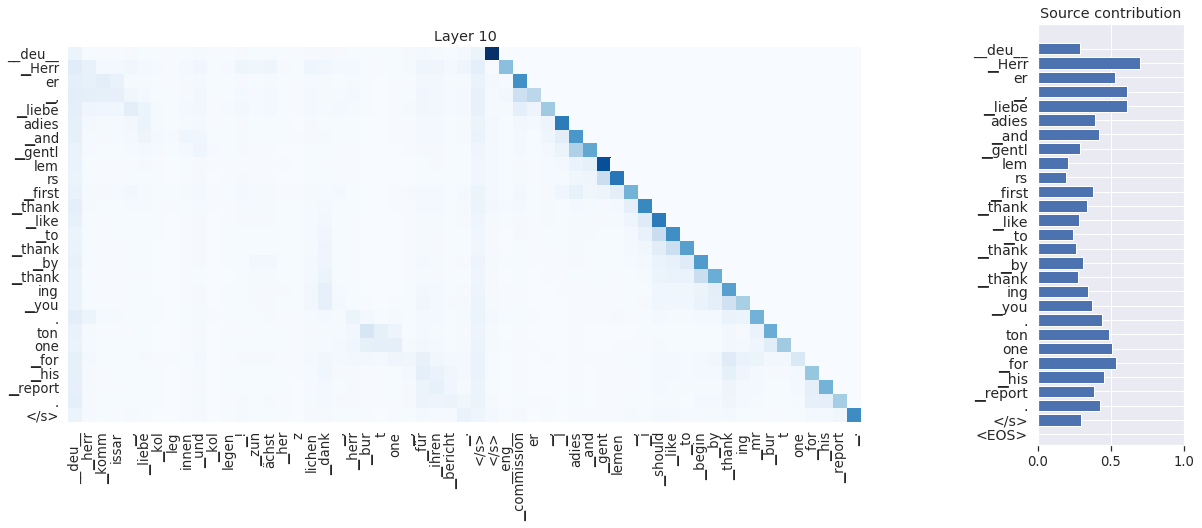

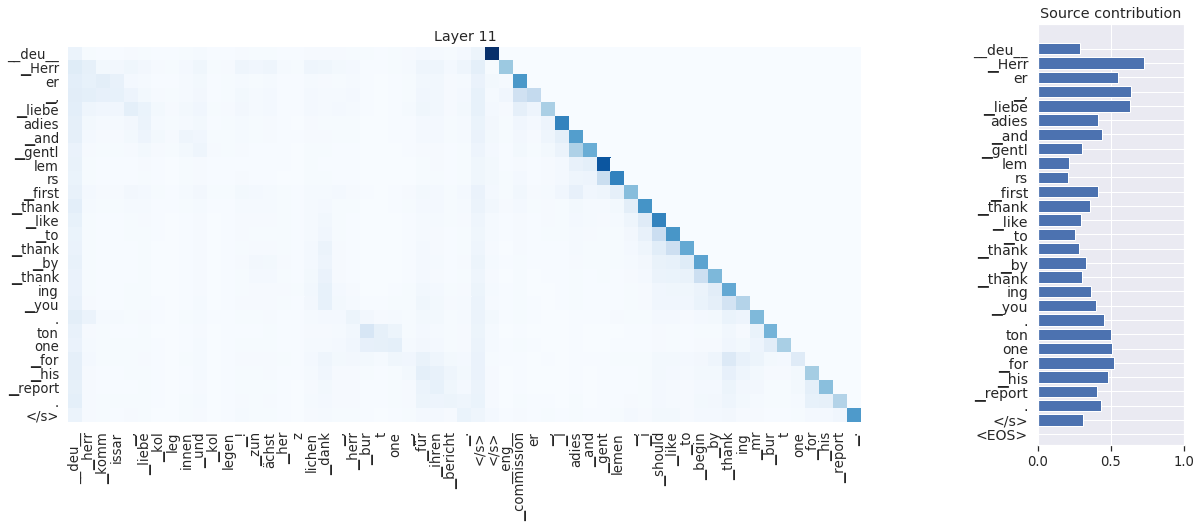

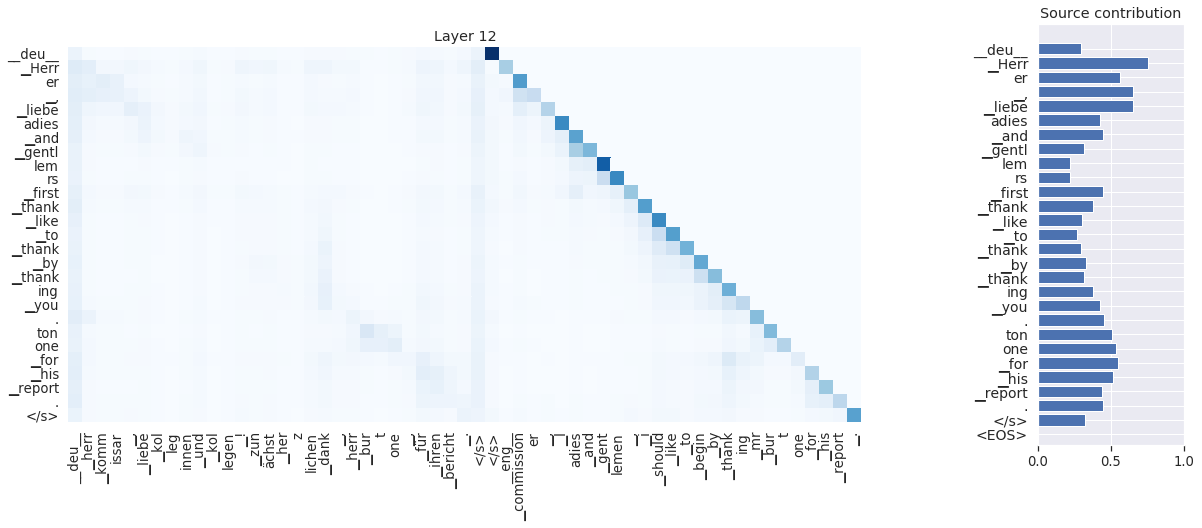

In [13]:
for layer in range(0,NUM_LAYERS):

    fig = plt.figure(figsize=(20, 24))
    gs = GridSpec(3, 4)
    gs.update(wspace=1.2, hspace=0.05)#0.015
    ax_main = plt.subplot(gs[0:3, :3])
    ax_yDist = plt.subplot(gs[1, 3])#, sharey=ax_main)
    
    contributions_rollout_layer = total_rollout[layer]
    contributions_rollout_layer_np = contributions_rollout_layer.detach().cpu().numpy()
    df = pd.DataFrame(contributions_rollout_layer_np, columns = source_sentence + target_sentence, index = predicted_sentence)
    sns.set(font_scale=1.2)
    sns.heatmap(df,cmap="Blues",square=True,ax=ax_main,cbar=False)#Reds,center=0
    src_contribution = contributions_rollout_layer_np[:,:len(src_tok)].sum(-1)

    df_src_contribution = pd.DataFrame(src_contribution, columns = ['src_contribution'], index = pred_tok)
    #sns.set_style("white")
    ax_yDist.barh(range(0,len(pred_tok)), df_src_contribution.src_contribution, align='center')
    plt.yticks(ticks = range(0,len(tgt_tok + ['<EOS>'])) ,labels = pred_tok + ['<EOS>'],fontsize='14')
    plt.gca().invert_yaxis()
    plt.grid(visible=True)
    ax_yDist.set_xlim(0,1)

    ax_main.set_title('Layer ' + str(layer+1))
    ax_yDist.set_title('Source contribution')
    #sns.despine(left=True, bottom=True)
    ax_yDist.xaxis.set_ticks_position("bottom")
    # ax_yDist.xaxis.grid(False)
    # ax_yDist.yaxis.grid(False)
    #plt.gcf().subplots_adjust(bottom=0.2)

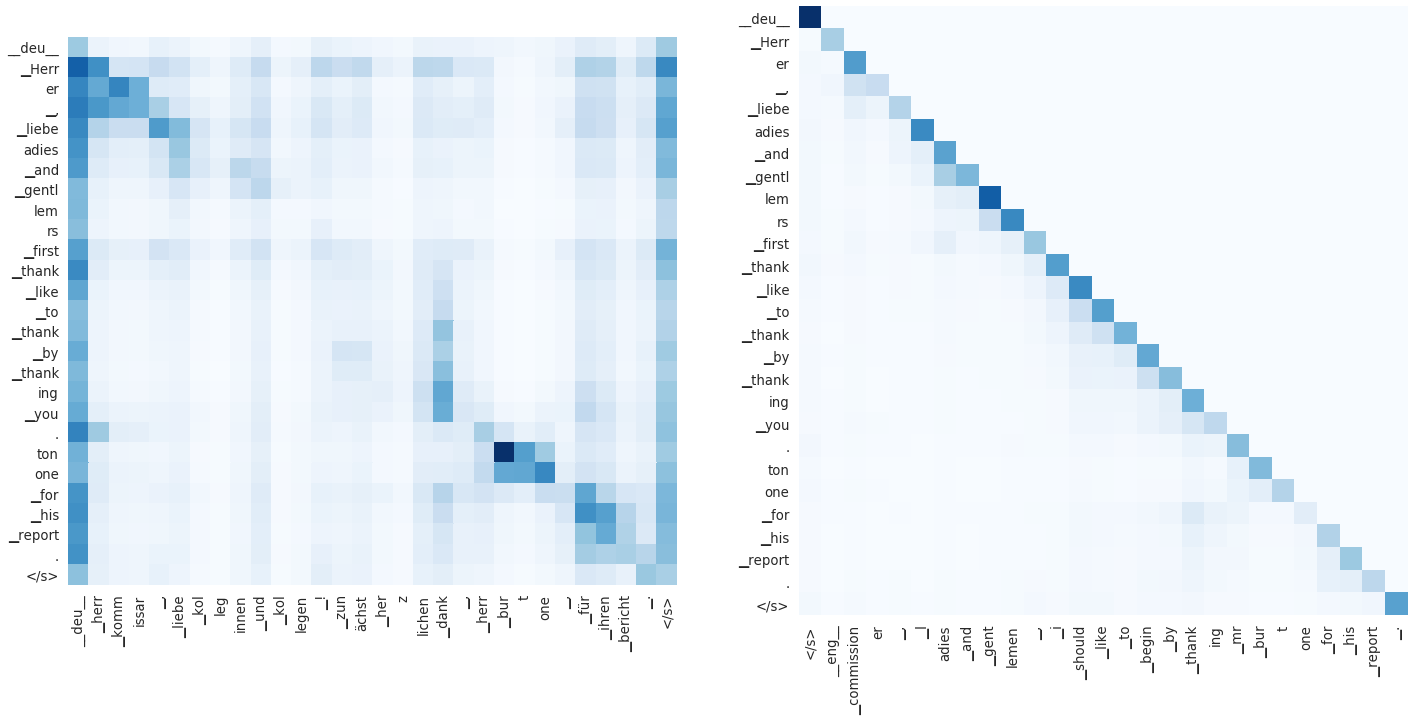

In [14]:
fig = plt.figure(figsize=(24, 14))
gs = GridSpec(1, 2)
gs.update(wspace=0.2, hspace=0.05)#0.015
ax_left = plt.subplot(gs[0, 0])
ax_right = plt.subplot(gs[0, 1])
df = pd.DataFrame(contributions_rollout_layer_np[:,:len(source_sentence)], columns = source_sentence, index = predicted_sentence)
sns.set(font_scale=1.2)
sns.heatmap(df,cmap="Blues",square=True,ax=ax_left,cbar=False)
df = pd.DataFrame(contributions_rollout_layer_np[:,len(source_sentence):len(source_sentence)+len(target_sentence)], columns = target_sentence, index = predicted_sentence)
sns.heatmap(df,cmap="Blues",square=True,ax=ax_right,cbar=False)
plt.gcf().subplots_adjust(bottom=0.2)

## Word-word alignments (source-target) from contributions

Currently only works for teacher forcing

In [17]:
src_tok_str = ' '.join(source_sentence[:-1])
src_word_sent = ''.join(source_sentence[:-1]).replace('▁', ' ')

In [18]:
tgt_tok_str = ' '.join(target_sentence[:-1])
tgt_word_sent = ''.join(target_sentence[:-1]).replace('▁', ' ')

In [19]:
contribution_pred_src = contributions_rollout_layer_np[:,:len(source_sentence)]
src_word_to_bpe = align.convert_bpe_word(src_tok_str, src_word_sent)
tgt_word_to_bpe = align.convert_bpe_word(tgt_tok_str, tgt_word_sent)
contributions_word_word = align.get_word_word_attention(contribution_pred_src, src_word_to_bpe, tgt_word_to_bpe, remove_EOS=False)
contributions_word_word.shape

(20, 21)

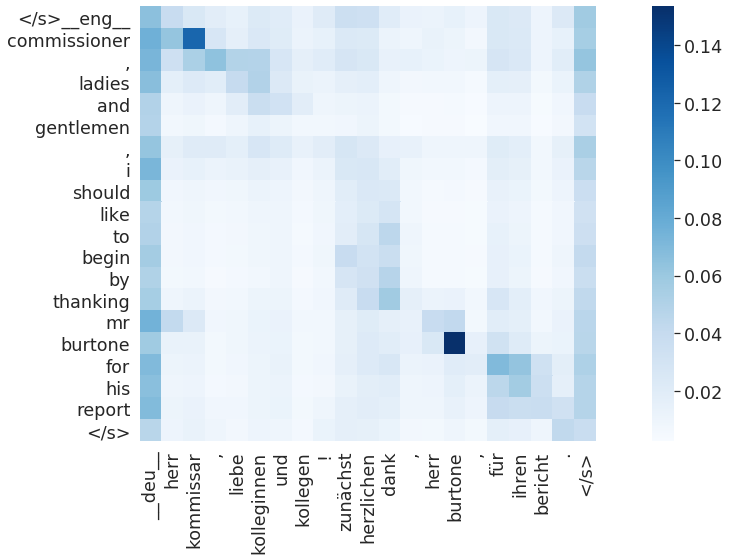

In [20]:
## Soft alignment
plt.figure(figsize=(20,8))
df = pd.DataFrame(contributions_word_word, columns = src_word_sent.split() + ['</s>'], index = tgt_word_sent.split() + ['</s>'])
sns.set(font_scale=1.6)
sns.heatmap(df,cmap="Blues",square=True,cbar=True);

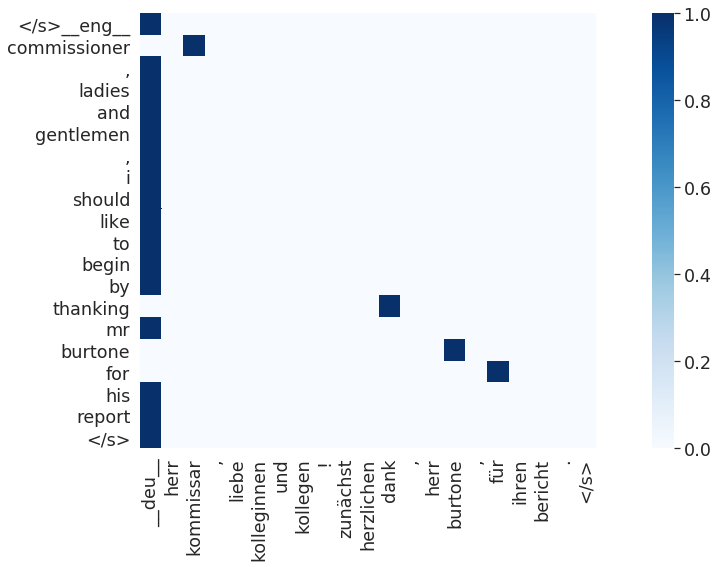

In [21]:
## Hard alignment
a_argmax = np.argmax(contributions_word_word, -1)
contributions_word_word_hard = np.zeros(contributions_word_word.shape)

for i, j in enumerate(a_argmax):
    contributions_word_word_hard[i][j] = 1

plt.figure(figsize=(20,8))
df = pd.DataFrame(contributions_word_word_hard, columns = src_word_sent.split() + ['</s>'], index = tgt_word_sent.split() + ['</s>'])
sns.set(font_scale=1.6)
sns.heatmap(df,cmap="Blues",square=True,cbar=True);